In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.layers import Dense,Input,LSTM,GlobalMaxPooling1D,Embedding,MaxPooling1D,Conv1D,Concatenate,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

In [ ]:
!wget --passive-ftp --prefer-family=ipv4 --ftp-user datasets@mmspgdata.epfl.ch  --ftp-password ohsh9jah4T -nc ftp://tremplin.epfl.ch//FoodImage/Food-5K.zip

--2022-09-20 16:45:30--  ftp://tremplin.epfl.ch//FoodImage/Food-5K.zip
           => ‘Food-5K.zip’
Resolving tremplin.epfl.ch (tremplin.epfl.ch)... 128.178.218.41, 2001:620:618:1da:7:80b2:da01:3
Connecting to tremplin.epfl.ch (tremplin.epfl.ch)|128.178.218.41|:21... connected.
Logging in as datasets@mmspgdata.epfl.ch ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /FoodImage ... done.
==> SIZE Food-5K.zip ... 446919921
==> PASV ... done.    ==> RETR Food-5K.zip ... done.
Length: 446919921 (426M) (unauthoritative)

Food-5K.zip         100%[===================>] 426.22M  16.7MB/s    in 27s     

2022-09-20 16:46:00 (15.6 MB/s) - ‘Food-5K.zip’ saved [446919921]



In [ ]:
!unzip -qq -o Food-5K.zip

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/validation 

!mkdir data/train/food
!mkdir data/train/non_food

!mkdir data/validation/food
!mkdir data/validation/non_food


!mv training/1* data/train/food
!mv training/0* data/train/non_food

!mv validation/1* data/validation/food
!mv validation/0* data/validation/non_food

In [ ]:
train_path= "data/train"
valid_path="data/validation"

In [ ]:
IMAGE_SIZE=[200,200]

image_files=glob(train_path+'/*/*.jpg')
valid_image_files=glob(valid_path+'/*/*.jpg')

folders=glob(train_path+'/*')
folders

['data/train/food', 'data/train/non_food']

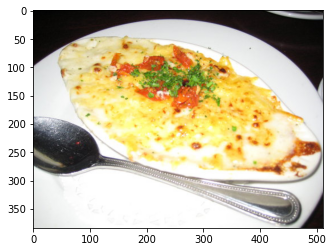

In [ ]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [ ]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
x=Flatten()(ptm.output)

In [ ]:
model=Model(inputs=ptm.input,outputs=x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen=ImageDataGenerator(
    preprocessing_function=preprocess_input
)
batch_size=128


train_generator=gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator=gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))

D = feat.shape[1]

X_train = np.zeros((Ntrain,D))
Y_train = np.zeros(Ntrain)

X_valid = np.zeros((Nvalid,D))
Y_valid = np.zeros(Nvalid)




In [ ]:
i = 0
for x,y in train_generator:
  features=model.predict(x)
  sz=len(y)

  X_train[i:i+sz] = features
  Y_train[i:i+sz] = y

  i+=sz
  print(i)

  if i>=Ntrain:
    print('breaking now')
    break
print(i)





128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [ ]:
X_train.max(),X_train.min()

(650.8262939453125, 0.0)

In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.fit_transform(X_valid)

In [ ]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

logr.fit(X_train2,Y_train)

print(logr.score(X_train2,Y_train))

print(logr.score(X_valid2,Y_valid))

1.0
1.0


In [ ]:
i =Input(shape=(D,))

x = Dense(1,activation='sigmoid')(i)
linearmodel = Model(i,x)

linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
r = linearmodel.fit(
    X_train,Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid,Y_valid)
)

Epoch 1/10
24/24 [==============================] - 1s 14ms/step - loss: 0.9545 - accuracy: 0.9340 - val_loss: 0.6958 - val_accuracy: 0.0000e+00
Epoch 2/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.9940 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 3/10
24/24 [==============================] - 0s 8ms/step - loss: 7.6606e-04 - accuracy: 0.9997 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 1.3340e-04 - accuracy: 1.0000 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 5/10
24/24 [==============================] - 0s 8ms/step - loss: 8.8902e-06 - accuracy: 1.0000 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 6/10
24/24 [==============================] - 0s 9ms/step - loss: 6.2213e-06 - accuracy: 1.0000 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 7/10
24/24 [==============================] - 0s 7ms/step - loss: 5.4373e-06 - accuracy: 1.0000 - val_loss: 0.695

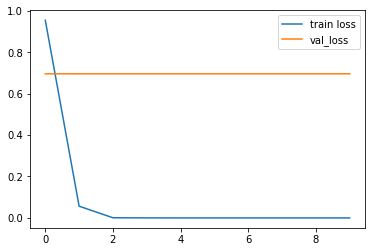

In [ ]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

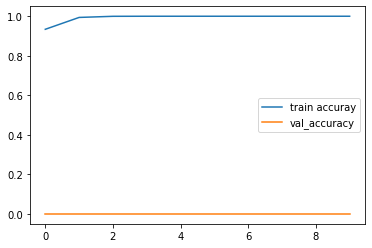

In [ ]:
plt.plot(r.history['accuracy'],label='train accuray')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()